Apply P3INN on Core 2 data to obtain many quantiles for it. FINN is then trained on these quantiles (Data-SPAN) to obtain many retardations. Including to the retardations, FINN will compute the C field for each quantile. Then I also have a UQ estimate for C.

In [1]:
import shutil
import importlib
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import lib
import p3inn

importlib.reload(lib)
importlib.reload(p3inn)

<module 'p3inn' from '/Users/r/Documents/stud/ss24/finnpinn/src/p3inn/__init__.py'>

# Run

In [2]:
data_out_root = Path("../data_out").resolve()
assert data_out_root.exists()
pi3nn_root = data_out_root / "p3inn"
finn_root = data_out_root / "finn"
pi3nn_root.mkdir(exist_ok=True, parents=True)
finn_root.mkdir(exist_ok=True, parents=True)

In [3]:
data_core2_df = lib.load_exp_data(name="Core 2")
display(data_core2_df.head())

,time,c_diss
0,0.000000,0.000000
1,0.838329,0.000096
2,1.377912,0.000062
3,1.879996,0.000061
4,2.379996,0.000052


### PI3NN on experimental data to obtain PIs for different quantiles

In [4]:
# x = data_core2_df["time"].to_numpy().squeeze()
# plt.figure()
# plt.plot(x, data_core2_df["c_diss"], ".")
# plt.plot(x, net_mean(x), "x")
# res = data_core2_df["c_diss"].to_numpy().squeeze() - net_mean(x).squeeze()
# _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
# ax1.plot(x[res>0], res[res>0], "x")
# ax2.plot(x[res<=0], res[res<=0], "x")
# plt.show()

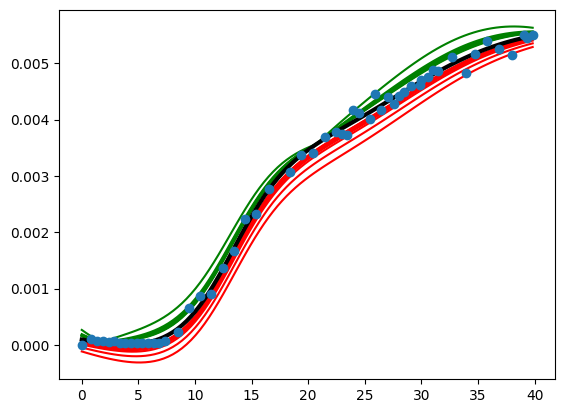

In [5]:
ref_dir = p3inn.P3innDir(Path("../data_out copy 20102024/p3inn/core2"))
for q, bound_up, bound_down in ref_dir.iter_pred_PIs():
    plt.plot(ref_dir.x_eval.load(), bound_up, "g-")
    plt.plot(ref_dir.x_eval.load(), bound_down, "r-")
plt.plot(ref_dir.x_eval.load(), ref_dir.pred_median.load(), "k-", lw=3)
plt.scatter(ref_dir.x_data.load(), ref_dir.y_data.load(), zorder=10)
plt.show()

[0.05 1.  ]
TrainingParams(max_epochs=50000, initial_learning_rate=0.1, batch_size=8, activation='tanh', loss_fun='mse', optimizer='adam', validation_fraction=0.2, stop_early=True, n_neurons_per_layer=[32]) TrainingParamsStd(max_epochs=1700, initial_learning_rate=0.01, batch_size=None, activation='tanh', loss_fun='mse', optimizer='adam', validation_fraction=0.1, stop_early=False, n_neurons_per_layer=[64]) ExperimentParams(out_dir=PosixPath('/Users/r/Documents/stud/ss24/finnpinn/data_out/p3inn/core2'), x_data_path=PosixPath('/Users/r/Documents/stud/ss24/finnpinn/data_out/p3inn/core2/x_data.npy'), y_data_path=PosixPath('/Users/r/Documents/stud/ss24/finnpinn/data_out/p3inn/core2/y_data.npy'), quantiles=[0.05, 1.0], seed=111859908, debug=False, visualize=True, load_checkpoint=True, positivity_method='softplus', verbose=1, l2_regularization=1e-05)


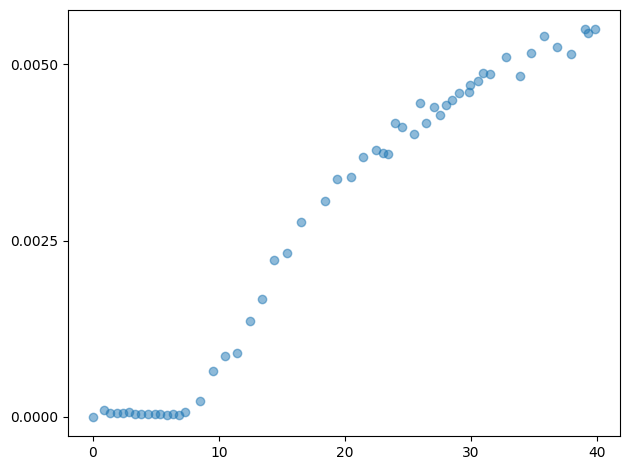

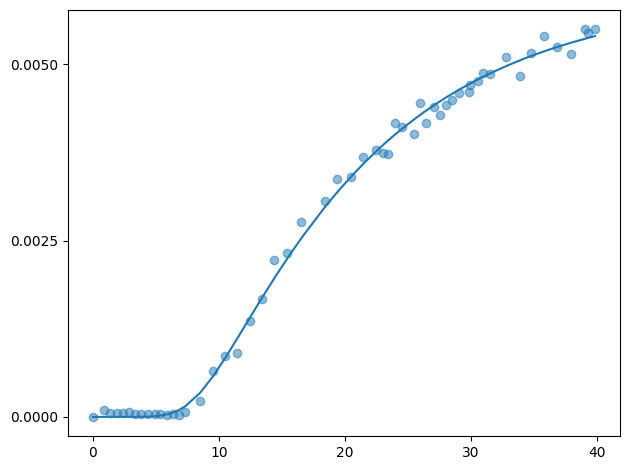

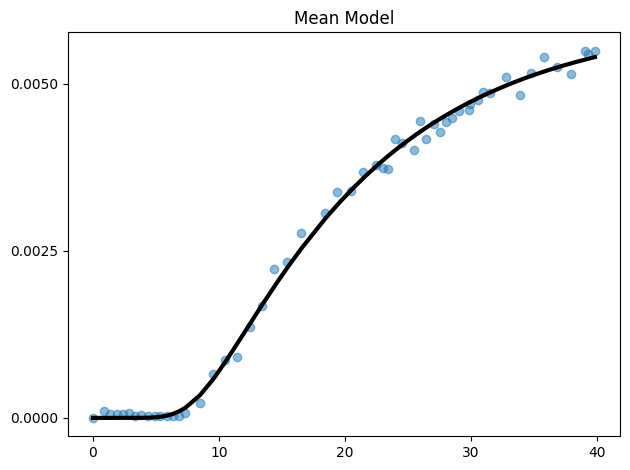

median_shift=1.7520734085160675e-05


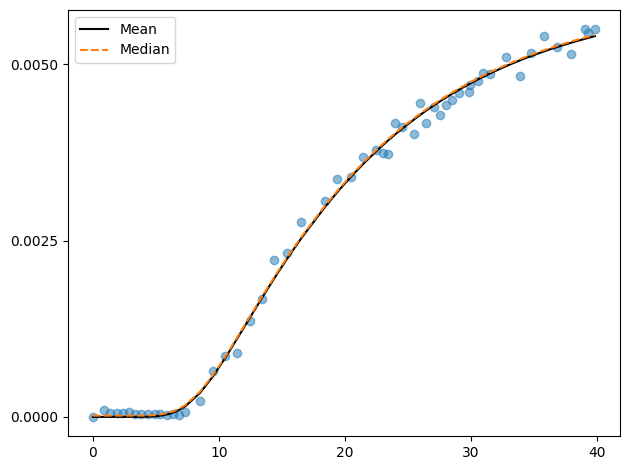

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


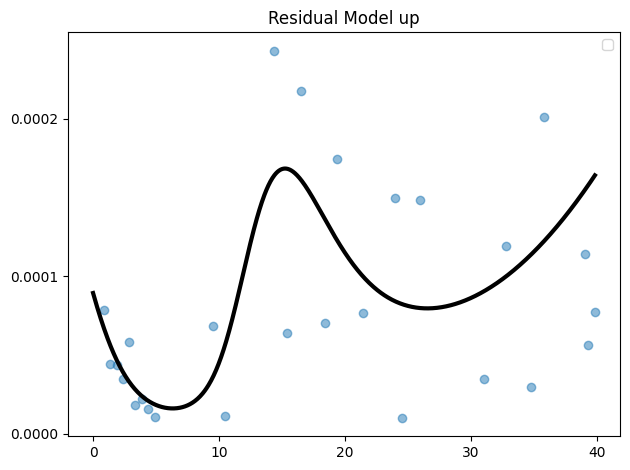

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


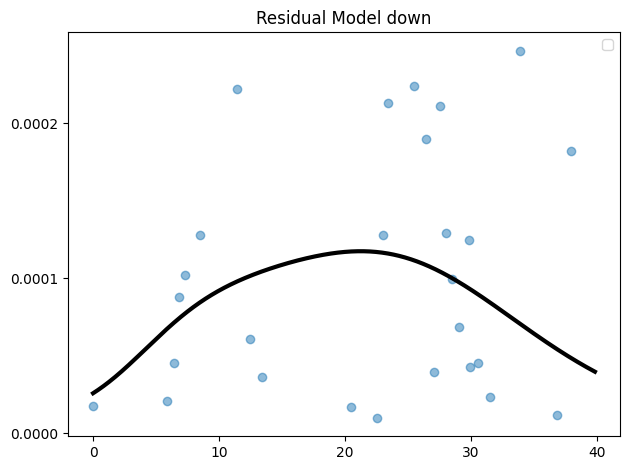

num_outliers=26 55
Initial bounds: [0.0, 1000000.0]
Initial vals: [2, -26]
Initial vals: [2, -26]
Optimal c: 0.17881393432617188, Final count: 0
num_outliers=26 55
Initial bounds: [0.0, 1000000.0]
Initial vals: [2, -26]
Initial vals: [2, -26]
Optimal c: 0.11920928955078125, Final count: 0
Quantile: 0.05
    c_up=0.178814
    c_down=0.119209

Saving quantiles...
    PI contains 5.5%

type(c2)=<class 'float'>
type(c2)=<class 'float'>
Quantile: 1.0
    c_up=1.90072
    c_down=3.76407

Saving quantiles...
    PI contains 100.0%



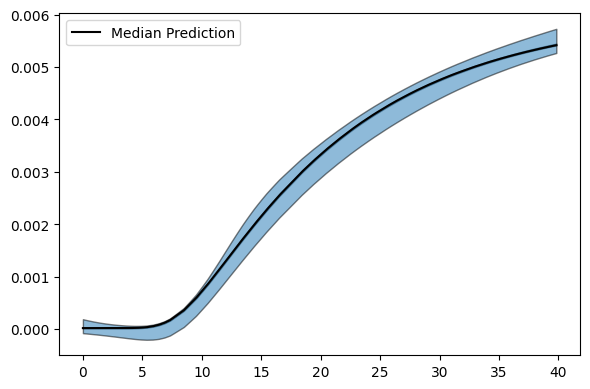

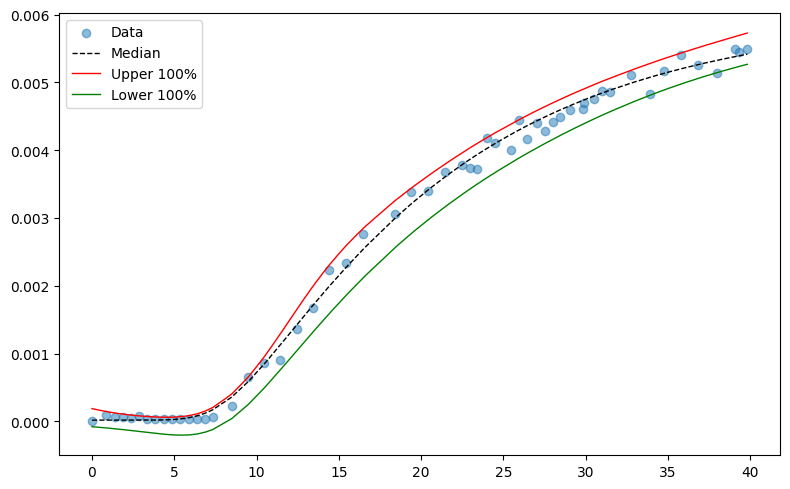

In [6]:
p3inn_core2_dir = p3inn.P3innDir(pi3nn_root / "core2")
# shutil.rmtree(p3inn_core2_dir.path.absolute())
# p3inn_core2_dir = p3inn.P3innDir(pi3nn_root / "core2")
p3inn_core2_dir.x_data.save(data_core2_df["time"].to_numpy().reshape(-1, 1))
p3inn_core2_dir.y_data.save(data_core2_df["c_diss"].to_numpy().reshape(-1, 1))

# quantiles = np.linspace(0.1, 0.95, 35, endpoint=True)
quantiles = np.array([0.05, 1.0])
print(quantiles)

finn_core2_dir = lib.FinnDir(Path("../data_out/finn/core2"))
fp = np.load(finn_core2_dir.get_data_pred_path(finn_core2_dir.best_epoch))
xp = np.load(finn_core2_dir.t_train_path)


def net_mean(x):
    y = np.interp(x, xp, fp).reshape(-1, 1)
    return y


p3inn.pi3nn_compute_PI_and_mean(
    out_dir=p3inn_core2_dir.path,
    quantiles=quantiles.tolist(),
    visualize=True,
    passed_net_mean=net_mean,
    # max_iter=10000,
    load_from_dir=True,
)

### FINN on all quantiles to obtain retardations

In [7]:
finn_exp_root = finn_root / "p3inn_core2_new_multiprocessing"
finn_exp_root

PosixPath('/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing')

In [8]:
conf_core2 = lib.load_exp_conf(name="Core 2")
display(conf_core2)

{'D': 2.0045664000000002e-05,
 'por': 0.288,
 'rho_s': 1957.0,
 'X': 0.026034999999999996,
 'T': 39.824440010000004,
 'Nx': 20.0,
 'Nt': 55.0,
 'sample_radius': 0.02375,
 'Q': 0.00010435199999999999,
 'solubility': 1.6,
 'Dirichlet': 0.0,
 'Cauchy': 1.0}

In [9]:
from pathlib import Path

# Prepare a list of commands to run in parallel
commands = []

for quantile, bound_up, bound_down in p3inn_core2_dir.iter_pred_PIs():
    for bound_type, bound in [("up", bound_up), ("down", bound_down)]:
        bound_file = Path(
            f"/tmp/bound_{bound_type}_{quantile:g}.npy"
        )  # Save bound data to file
        np.save(bound_file, bound)

        finn_dir = lib.FinnDir(finn_exp_root / f"{bound_type}_{quantile:g}")
        # print(finn_dir.path.resolve())

        command = f"python3 run_finn_core2.py {finn_dir.path.resolve()} {bound_file} > ../data_out/logs/{quantile:g}_{bound_type}.txt"
        commands.append(command)

In [10]:
# Write all commands to a temporary file (input for GNU Parallel)
commands_file = Path("/tmp/parallel_commands.txt")
with open(commands_file, "w") as f:
    f.write("\n".join(commands))
print(commands_file.resolve())

/private/tmp/parallel_commands.txt


In [11]:
command = f"cat {commands_file} | parallel -j 6 --bar"
# subprocess.run(command, check=True, shell=True)
print(command)

cat /tmp/parallel_commands.txt | parallel -j 6 --bar


In [12]:
!cat /tmp/parallel_commands.txt

python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.05 /tmp/bound_up_0.05.npy > ../data_out/logs/0.05_up.txt
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.05 /tmp/bound_down_0.05.npy > ../data_out/logs/0.05_down.txt
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.1 /tmp/bound_up_0.1.npy > ../data_out/logs/0.1_up.txt
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.1 /tmp/bound_down_0.1.npy > ../data_out/logs/0.1_down.txt
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.125 /tmp/bound_up_0.125.npy > ../data_out/logs/0.125_up.txt
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.125 /tmp/bound